In [ ]:
!nvidia-smi

Tue Oct 27 15:41:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


## Prerequisites

Let's start by installing some required libraries by the YOLOv5 project:

In [ ]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-l7uqrnpf
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-l7uqrnpf
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266456 sha256=556f2c954c4d63b0fc1c52649e5e21938daaa6034fa708b985dc2bbfea41ab3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ka8q3cq7/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools


We'll also need to install [Apex by NVIDIA](https://nvidia.github.io/apex/) to speed up the training of our model (this step is optional):

In [ ]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Cloning into 'apex'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 7456 (delta 0), reused 0 (delta 0), pack-reused 7455
Receiving objects: 100% (7456/7456), 13.91 MiB | 27.02 MiB/s, done.
Resolving deltas: 100% (5038/5038), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-kwfhypcm
Created temporary directory: /tmp/pip-req-tracker-47l5ch3j
Created requirements tracker '/tmp/pip-req-tracker-47l5ch3j'
Created temporary directory: /tmp/pip-install-0xrfwvpm
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-10frtq8e
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-47l5ch3j'
    Running setup.py (path:/tmp/pip-req-build-10frtq8e/setup.py) egg_info 

## Build a dataset

The dataset contains annotations for clothing items - bounding boxes around shirts, tops, jackets, sunglasses. The dataset is from [DataTurks](https://dataturks.com/) and is on [Kaggle](https://www.kaggle.com/dataturks/clothing-item-detection-for-ecommerce).

In [ ]:
!gdown --id 1uWdQ2kn25RSQITtBHa9_zayplm27IXNC

Downloading...
From: https://drive.google.com/uc?id=1uWdQ2kn25RSQITtBHa9_zayplm27IXNC
To: /content/clothing.json
100% 199k/199k [00:00<00:00, 58.4MB/s]


The dataset contains a single JSON file with URLs to all images and bounding box data.

In [ ]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

Each line in the dataset file contains a JSON object. Let's create a list of all annotations:

In [ ]:
clothing = []
with open("clothing.json") as f:
    for line in f:
        clothing.append(json.loads(line))

Annotation example

In [ ]:
clothing[0]

{'annotation': [{'imageHeight': 312,
   'imageWidth': 147,
   'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.02040816326530612, 'y': 0.2532051282051282},
    {'x': 0.9931972789115646, 'y': 0.8108974358974359}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/4bb8fd9d-8d52-46c7-aa2a-9c18af10aed6___Data_xxl-top-4437-jolliy-original-imaekasxahykhd3t.jpeg',
 'extras': None}

We have the labels, image dimensions, bounding box points (normalized in 0-1 range), and an URL to the image file.


In [ ]:
for c in clothing:
  if len(c['annotation']) > 1:
    display(c)

{'annotation': [{'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Jackets'],
   'notes': '',
   'points': [{'x': 0, 'y': 0.6185897435897436},
    {'x': 0.026415094339622643, 'y': 0.6185897435897436}]},
  {'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Skirts'],
   'notes': '',
   'points': [{'x': 0.01509433962264151, 'y': 0.03205128205128205},
    {'x': 1, 'y': 0.9839743589743589}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/b3be330c-c211-45bb-b244-11aef08021c8___Data_free-sk-5108-mudrika-original-imaf4fz626pegq9f.jpeg',
 'extras': None}

Unique Categories

In [ ]:
categories = []
for c in clothing:
  for a in c['annotation']:
    categories.extend(a['label'])
categories = list(set(categories))
categories.sort()
categories

['Jackets',
 'Jeans',
 'Shirts',
 'Shoes',
 'Skirts',
 'Tops',
 'Trousers',
 'Tshirts',
 'sunglasses']

We have 9 different categories. Let's split the data into a training and validation set:

In [ ]:
train_clothing, val_clothing = train_test_split(clothing, test_size=0.1)
len(train_clothing), len(val_clothing)

(453, 51)

### Sample image and annotation


In [ ]:
row = train_clothing[12]

img = urllib.request.urlopen(row["content"])
img = Image.open(img)
img = img.convert('RGB')

img.save("demo_image.jpeg", "JPEG")

In [ ]:
row

{'annotation': [{'imageHeight': 312,
   'imageWidth': 151,
   'label': ['Tshirts'],
   'notes': '',
   'points': [{'x': 0.019867549668874173, 'y': 0.20512820512820512},
    {'x': 1, 'y': 0.8397435897435898}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/809b7d24-9031-4faf-ad74-66b83ddc7c4a___Data_xl-rt021-leana-original-imafyguj4gfp6sey.jpeg',
 'extras': None}

We can use OpenCV to read the image:

In [ ]:
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
img.shape

(312, 151, 3)

Let's add the bounding box on top of the image along with the label:

In [ ]:
for a in row['annotation']:
  for label in a['label']:

    w = a['imageWidth']
    h = a['imageHeight']

    points = a['points']
    p1, p2 = points

    x1, y1 = p1['x'] * w, p1['y'] * h
    x2, y2 = p2['x'] * w, p2['y'] * h

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x2), int(y2)),
      color=(0, 255, 0),
      thickness=2
    )

    ((label_width, label_height), _) = cv2.getTextSize(
        label, 
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75, 
        thickness=2
    )

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
      color=(0, 255, 0),
      thickness=cv2.FILLED
    )

    cv2.putText(
      img,
      label,
      org=(int(x1), int(y1 + label_height + label_height * 0.25)), # bottom left
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2
    )

The point coordinates are converted back to pixels and used to draw rectangles over the image. Here's the result:

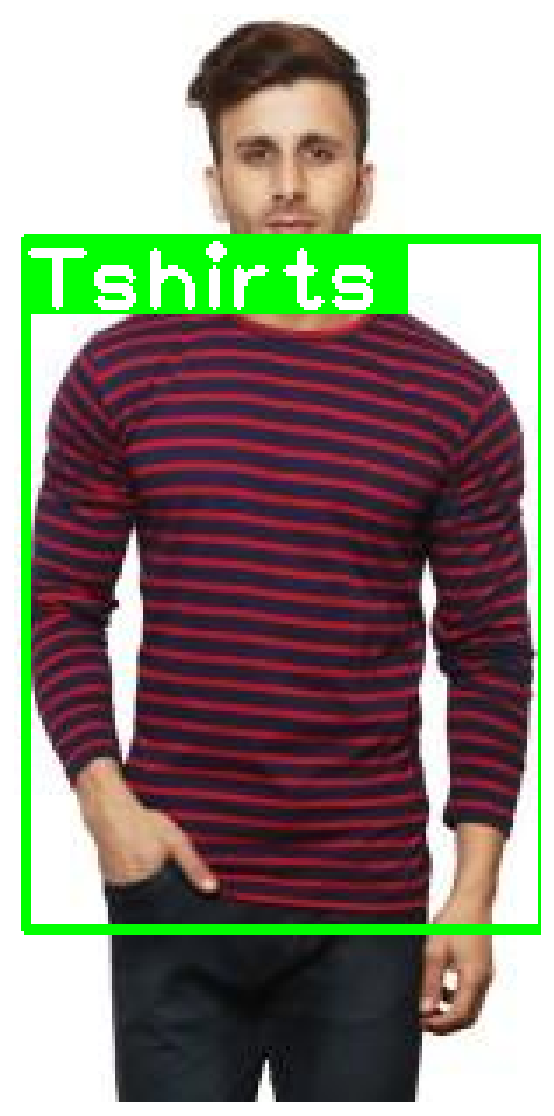

In [ ]:
plt.imshow(img)
plt.axis('off');

### Convert to YOLO format

YOLO v5 requires the dataset to be in the *darknet format*. Here's an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: `class_index bbox_x_center bbox_y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1


In [ ]:
def create_dataset(clothing, categories, dataset_type):

  images_path = Path(f"clothing/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)

  labels_path = Path(f"clothing/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)

  for img_id, row in enumerate(tqdm(clothing)):

    image_name = f"{img_id}.jpeg"

    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert("RGB")

    img.save(str(images_path / image_name), "JPEG")

    label_name = f"{img_id}.txt"

    with (labels_path / label_name).open(mode="w") as label_file:

      for a in row['annotation']:

        for label in a['label']:

          category_idx = categories.index(label)

          points = a['points']
          p1, p2 = points

          x1, y1 = p1['x'], p1['y']
          x2, y2 = p2['x'], p2['y']

          bbox_width = x2 - x1
          bbox_height = y2 - y1

          label_file.write(
            f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
          )

In [ ]:
create_dataset(train_clothing, categories, 'train')
create_dataset(val_clothing, categories, 'val')

100%|██████████| 51/51 [00:02<00:00, 19.31it/s]


In [ ]:
!tree clothing -L 2

clothing
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


In [ ]:
!cat clothing/labels/train/0.txt

4 0.525462962962963 0.5432692307692308 0.9027777777777778 0.9006410256410257


## Fine-tuning YOLO v5

YOLO uses PyTorch library to function

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

Cloning into 'yolov5'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 2690 (delta 0), reused 0 (delta 0), pack-reused 2685
Receiving objects: 100% (2690/2690), 5.44 MiB | 33.77 MiB/s, done.
Resolving deltas: 100% (1776/1776), done.
/content/yolov5
Note: checking out 'ec72eea62bf5bb86b0272f2e65e413957533507f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ec72eea Merge remote-tracking branch 'origin/master'


We need two configuration files. One for the dataset and one for the model we're going to use. Let's download them:

In [ ]:
!gdown --id 1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO -O data/clothing.yaml
!gdown --id 1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i -O models/yolov5s.yaml

Downloading...
From: https://drive.google.com/uc?id=1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO
To: /content/yolov5/data/clothing.yaml
100% 172/172 [00:00<00:00, 312kB/s]
Downloading...
From: https://drive.google.com/uc?id=1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i
To: /content/yolov5/models/yolov5s.yaml
100% 1.58k/1.58k [00:00<00:00, 2.38MB/s]



```yaml
train: ../clothing/images/train/
val: ../clothing/images/val/

nc: 9

names: ['Jackets', 'Jeans', 'Shirts', 'Shoes', 'Skirts', 'Tops', 'Trousers', 'Tshirts', 'sunglasses']
```



### Training

Fine-tuning an existing model is very easy. We'll use the largest model **YOLOv5x** (89M parameters), which is also the most accurate.

In our case, we don't really care about speed. We just want the best accuracy you can get. The checkpoint you're going to use for a different problem(s) is contextually specific. [Take a look at the overview of the pre-trained checkpoints](https://github.com/ultralytics/yolov5/blob/f9ae460eeccd30bdc43a89a37f74b9cc7b93d52f/README.md#pretrained-checkpoints).

To train a model on a custom dataset, we'll call the `train.py` script. We'll pass a couple of parameters:

- img 640 - resize the images to 640x640 pixels
- batch 4 - 4 images per batch
- epochs 30 - train for 30 epochs
- data ./data/clothing.yaml - path to dataset config
- cfg ./models/yolov5x.yaml - model config
- weights yolov5x.pt - use pre-trained weights from the YOLOv5x model
- name yolov5x_clothing - name of our model
- cache - cache dataset images for faster training


In [ ]:
!python train.py --img 640 --batch 4 --epochs 30 --data ./data/clothing.yaml --cfg ./models/yolov5s.yaml 

{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=4, bucket='', cache_images=False, cfg='./models/yolov5s.yaml', data='./data/clothing.yaml', device='', epochs=30, evolve=False, img_size=[640], multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='')
Using CUDA Apex device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

2020-10-27 16:03:44.018833: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/

              from  n    params  module                                  arguments           

The training took around 30 minutes on Tesla P100. The best model checkpoint is saved to `weights/best_yolov5x_clothing.pt`.

## Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

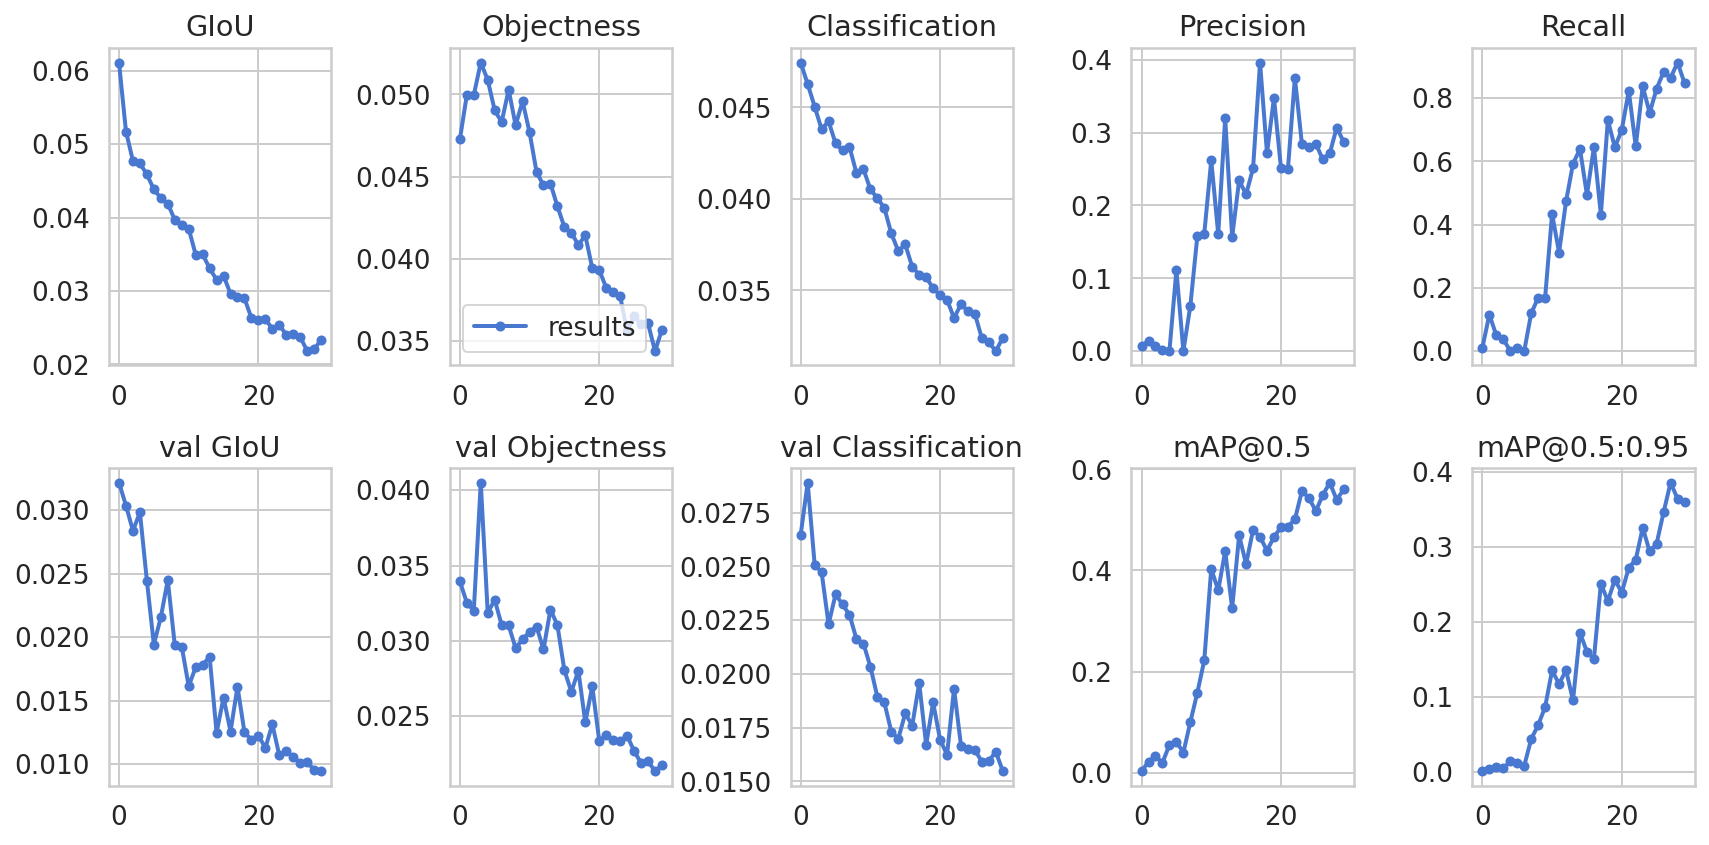

In [ ]:
from utils.utils import plot_results

plot_results();

Looks like the mean average precision (mAP) is getting better throughout the training. The model might benefit from more training, but it is good enough.

## References

- [Clothing Item Detection for E-Commerce dataset](https://www.kaggle.com/dataturks/clothing-item-detection-for-ecommerce)
- [YOLOv5 GitHub](https://github.com/ultralytics/yolov5)
- [YOLOv5 Train on Custom Data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)
- [NVIDIA Apex on GitHub](https://github.com/NVIDIA/apex)
- [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/pdf/2004.10934.pdf)